In [1]:
# Importing necessary function 

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random 
import scipy.stats as sts
import time 

# Experimenting with networkx libary and basic set up

12


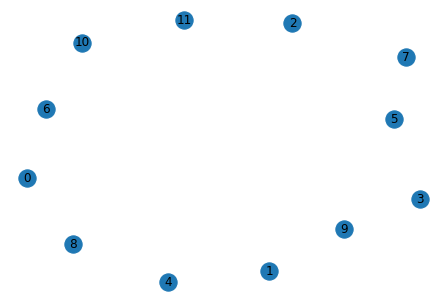

12


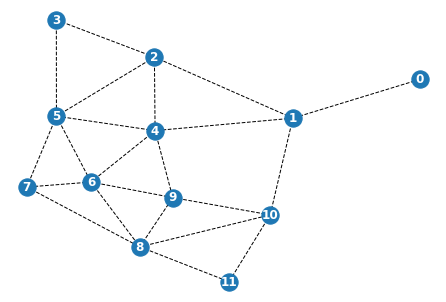

In [2]:
taipei = nx.empty_graph(12)
nx.draw(taipei,with_labels=True)
print(taipei.number_of_nodes())
plt.show()
pos = nx.circular_layout(taipei)

# Add edges between two districts that are connected
# The weight of the edge is the average travel time from one node to the other joined by an edge
connected_areas = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]

# Add the weighted edges to the network
taipei.add_weighted_edges_from(connected_areas)

# Visauzlie the network
nx.draw(taipei, with_labels=True, font_weight='bold', font_color = 'white',style="dashed")
print(taipei.number_of_nodes())

plt.show()




# Set up the model 

We created three python classes for the simulation.
- **simulation**: This is where the simulation happens. It contains the district and time and helps keeping track of systematic behaior.
- **district**: This is contains the patient and is where we keep track of district level behavior, including the number of ambulance and wait time for each patient.  
- **patient**: This class keeps track of the time each patient waited for the amublance service.

In [40]:
# We need a class for the patient to keep track of their waiting time
class patient:
    '''
    This class keeps track of the time each patient waited for the amublance service.
    '''
    def __init__(self, time):
        '''
        ---
        Input
        ---
            - time: the time when the patient/caller calls. 
        '''
        # Keep track of the start time
        self.start_time = time
    


class district:
    '''
    This is contains the patient and is where we keep track of district level behavior, 
    including the number of ambulance and wait time for each patient.  
    '''
    
    def __init__(self,num):
        '''
        ---
        Input
        ---
            - num: int: The number of ambulance car
            
        ---
        OtherParameters
        ---
            - patient: list: Keep track of the patient in terms of where they are from, when they will be back at the hospital, also their start time.
            - amb_back_time: list: We need to keep track of when the car will come back with the station car
            - wait_time: list: keep track of the time each patient eaited
        '''
        self.num_amb = num 
        self.patient = []
        self.amb_back_time = []
        self.wait_time = []
    
    def update(self,current_time):
        '''
        Update the ambulance station to see if any ambulance is coming back 
        and keep track of waiting time
        '''
        
        # we will sort the patient in order of when they willl be back at the hospital 
        self.patient = sorted(self.patient, key=lambda x: x[0])
        
        # we will sort the ambulance schedule in order of when they willl be back at the hospital 
        self.amb_back_time = sorted(self.amb_back_time)
        
        # Find out how many ambulances are coming back now
        back_time = np.array(self.amb_back_time)
        number = len(np.where(back_time == current_time)[0])
        
        # If there are ambulances scheduled to come back now, 
        # add the ambulance back to the station 
        if current_time in self.amb_back_time:
            self.num_amb += number
        
        # Keep track of how long did the patient wait and delete them from the patient service waitlist
        for i in range(number):
            self.wait_time.append(current_time - self.patient[0][2].start_time)
            del self.patient[0]
            
    
    def send_car(self,travel_time, current_time, district):
        '''
        Send the ambulance out when there are new patients 
        '''
        # Create a variable to store the return time
        return_time = 0
        
        # Pick an ambulance 
        self.num_amb -= 1

        # Schedule a return time 
        
        # Calculate the time to get to the scene, which is defined as the shortest weight path length 
        # plus or minus the time to travel within the city (randomly generated)
        # the minimum get to site time would be 1 min because it's impossible to get there in no time.
        get_to_site_time = max(1, (travel_time + random.randint(-6,6))) 

        # Add the on-site service time 
        if random.random()<0.95:
            on_site_time = 1
        else: 
            on_site_time = 10

        get_back_time = travel_time
        
        # Putting together the time it takes for ambulance to return
        return_time = current_time+ get_to_site_time+ on_site_time+ get_back_time
        
        # keep track of the patient 
        self.patient.append((return_time, district, patient(current_time)) )
        
        # Add to the schedule about the return time
        self.amb_back_time.append(return_time)
    
    
class simulation:
    '''
    This is where the simulation happens. It contains the district and time and helps keeping track of systematic behaior.
    '''
    
    # initialize the simulation with the probability for each district 
    def __init__(self,weighted_edges, average_call_time,amb_deploy, population):
        '''
        ---
        Input:
        ---
            - weighted_edges: A list for the weighted edges between nodes
            - We will initialize within each district (node) with a disctrict class as the property
            - average_call_time: A exponential Distribution for incoming patient call with the average time of 0.5 seconds  

        ---
        Other parameters:
        ---
            - time: A int to keep track of the current time 
            - total_wait_time: A int to keep track of the total wait time of the patients
            - dist_ambulance: A list to keep track of the Distribution of number of ambulance over time. 
            - amb_deploy: a list of tuples with indexes where we will put the ambulance in 
              and number of ambulance we put into each district
            - district_list: list: keep track of the index of the district 
            - nearest_station: dict: Keeping track of the distance to each ambulance station for each district in order of proximity

        '''
        self.graph = nx.empty_graph(12)
        self.weighted_edges = weighted_edges
        self.graph.add_weighted_edges_from(self.weighted_edges)
        self.average_call_time = average_call_time
        self.population = population 
        self.time = 0
        self.total_wait_time = []
        self.dist_ambulance = {}
        
        self.amb_deploy = amb_deploy
        self.district_list = [dist for (dist,num) in amb_deploy]
        
        # Build a hash table to keep track of the shortest path to the nearest centers
        self.shortest_path = dict(nx.all_pairs_shortest_path(self.graph))
        self.nearest_station = {}

        for i in self.shortest_path:
            temp = {}
            for j in self.shortest_path[i]:
                if j in self.district_list:
                    temp[j] =(self.shortest_path[i][j])


            self.nearest_station[i] = sorted(temp.items(), key=lambda x: x[1])
    


    def initialize(self):
        '''
        initialize the ambulances within a node
        '''
        for i, (idx,num) in enumerate(self.amb_deploy):
            # num is the number of ambulance we want to put into each stationn
            self.graph.nodes[idx]['district'] = district(num)
            self.dist_ambulance[idx] = []
    
    
    def update(self):
        '''
        update the system for one time step
        '''
        
        # update each ambulance station 
        # Keep track of the amublance distribution
        for i in self.district_list:
            self.graph.nodes[i]['district'].update(self.time)
            self.dist_ambulance[i].append(self.graph.nodes[i]['district'].num_amb)

            
        # choose two district to have accidents and create a patient object
        for calls in range(int(1/self.average_call_time)):
            
            prob = random.uniform(0,1)
        
            # Assign probability to each district 
            population_proportion = np.zeros(len(self.population))
            num = 0
            
            for i in range(len(self.population)):
                num += self.population[i]
                population_proportion[i] = (num)
            population_proportion = population_proportion/100

            #find that district
            district = min(np.where( population_proportion> prob)[0])

            
            n = 0 # to make sure that our simulation would stop when there is not enough ambulance, which is not allowed given our assumption 
            # find the closest stations
            while n <len(self.nearest_station[district]):
                amb_station = self.nearest_station[district][n][0]
                travel_time = sum(self.nearest_station[district][n][1])

                # go into those stations and get the ambulance out 
                # check if there are more ambulance:
                if self.graph.nodes[amb_station]['district'].num_amb!= 0:
                    self.graph.nodes[amb_station]['district'].send_car(travel_time,self.time,district)    
                    break
                    
                # if there is no amabulance in that station, go to the next-nearest station
                n+=1
            
            # if there is no ambulance in any station, we need to update the 
            # simulation because we cannot have people waitinng
            if n == len(self.nearest_station[district]):
                raise ValueError("Need more Amubulance")
            
        # increas the time    
        self.time += 1
        
    def observe(self):
        '''
        Call this method to observe the system at any given time poinnt
            - Average Wait time
            - Avaerage Number of ambulance in each district 
            - Number of ambulance in each distraict over time
            - Patient info in each district
        '''
        
        print(f"⏰ = {self.time}\n")
        
        print(f"Starting Ambulance Deployment:")
        for (district,num) in self.amb_deploy:
            print(f"District {district}: {num} 🚑")
            
        
        for i in self.district_list:  
            self.total_wait_time += ((self.graph.nodes[i]['district'].wait_time))

        print(f"\nAverage Wait Time: {np.mean(self.total_wait_time)}min\n")
        
        print("Number of 🚑 in each district:")
        for i in self.district_list:    
            print(f"District {i}: {self.graph.nodes[i]['district'].num_amb}" )
        
        print(f'\nNumber of 🚑 in ecah district over time\n')
        district_ambulance_idle = np.zeros(self.time)
        
        for i in self.district_list:
            plt.plot([x for x in range(self.time)], self.dist_ambulance[i], label = f'Ambulance distribution for Dist.{i}')
            district_ambulance_idle += np.array(self.dist_ambulance[i]) 
            
        district_ambulance_idle = district_ambulance_idle / len(self.district_list)
        plt.xlabel('Time Step')
        plt.xlabel('Number of Ambulance')
        
        plt.legend()
        plt.show()
        
        print(f'Average Number of IDLING 🚑 Over Time: {np.mean(district_ambulance_idle[200:])}')
        
        plt.plot([x for x in range(self.time)],district_ambulance_idle, label ='Number of IDLEING Ambulance Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Number of Ambulance')
        plt.title('Number of IDLEING Ambulance in Taipei Over Time')
        plt.show()
        
        
        print("\n")
        print("Patient info for each district:")
        for i in self.district_list:
            patient = [(f'⌛️: {time}', f'Dist: {district}') for (time,district, patientobject) in taipei.graph.nodes[i]['district'].patient]
            print(f"District {i}: {patient}\n" )
            

        
        



# Experimenting with our code - Test Reliability

In [42]:
# Observe behavior over time 
# created this to see whether the average wait time has reached equilibrium after 1440 time steps

weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]

average_call_time = 0.5 
amb_deploy = [(8,20), (6,20),(1,20)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])



results = []
timestep = np.linspace(1,1440, 24)

for j in timestep:
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(int(j)):
        taipei.update()
    
    for s in taipei.district_list:  
        taipei.total_wait_time += (taipei.graph.nodes[s]['district'].wait_time)

    results.append(np.mean(taipei.total_wait_time))

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'Observation of Average Wait Time over Time')

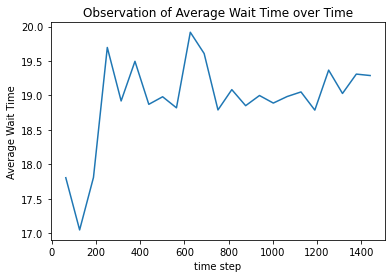

In [45]:
plt.plot(timestep, results)
plt.xlabel('time step')
plt.ylabel('Average Wait Time')
plt.title('Observation of Average Wait Time over Time')

We can see that even though there is fluctuation, the avereage wait time has reached a equilibrium after roughly 200 steps

In [101]:
# Check whether our code would tell us when the system (city) is running out of ambulances

weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]

average_call_time = 0.5 
amb_deploy = [(4,20), (6,20),(9,20)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])


taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
taipei.initialize()
for i in range(1440):
    taipei.update()

for s in taipei.district_list: 
    taipei.total_wait_time += taipei.graph.nodes[s]['district'].wait_time

taipei.observe()

ValueError: Need more Amubulance

⏰ = 1440

Starting Ambulance Deployment:
District 1: 20 🚑
District 6: 20 🚑
District 8: 20 🚑

Average Wait Time: 19.5103909827404min

Number of 🚑 in each district:
District 1: 0
District 6: 9
District 8: 10

Number of 🚑 in ecah district over time



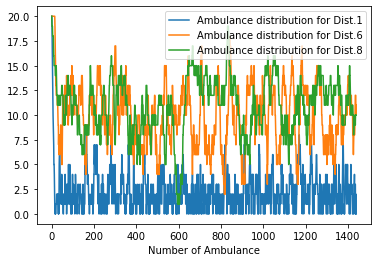

Average Number of IDLING 🚑 Over Time: 7.6174731182795705


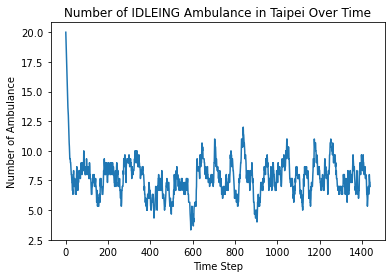



Patient info for each district:
District 1: [('⌛️: 1441', 'Dist: 10'), ('⌛️: 1442', 'Dist: 3'), ('⌛️: 1443', 'Dist: 7'), ('⌛️: 1444', 'Dist: 10'), ('⌛️: 1444', 'Dist: 4'), ('⌛️: 1445', 'Dist: 10'), ('⌛️: 1447', 'Dist: 7'), ('⌛️: 1447', 'Dist: 10'), ('⌛️: 1447', 'Dist: 3'), ('⌛️: 1448', 'Dist: 7'), ('⌛️: 1449', 'Dist: 9'), ('⌛️: 1452', 'Dist: 7'), ('⌛️: 1452', 'Dist: 5'), ('⌛️: 1454', 'Dist: 3'), ('⌛️: 1458', 'Dist: 9'), ('⌛️: 1458', 'Dist: 7'), ('⌛️: 1461', 'Dist: 10'), ('⌛️: 1464', 'Dist: 9'), ('⌛️: 1466', 'Dist: 10'), ('⌛️: 1473', 'Dist: 9')]

District 6: [('⌛️: 1441', 'Dist: 6'), ('⌛️: 1444', 'Dist: 6'), ('⌛️: 1446', 'Dist: 1'), ('⌛️: 1447', 'Dist: 0'), ('⌛️: 1452', 'Dist: 5'), ('⌛️: 1457', 'Dist: 1'), ('⌛️: 1462', 'Dist: 4'), ('⌛️: 1466', 'Dist: 0'), ('⌛️: 1467', 'Dist: 9'), ('⌛️: 1450', 'Dist: 6'), ('⌛️: 1460', 'Dist: 0')]

District 8: [('⌛️: 1440', 'Dist: 8'), ('⌛️: 1443', 'Dist: 11'), ('⌛️: 1447', 'Dist: 11'), ('⌛️: 1449', 'Dist: 10'), ('⌛️: 1449', 'Dist: 10'), ('⌛️: 1450', 'D

In [102]:
# We use some input to see the snapshot of the system after running 1440 steps for ONE trial

weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]

average_call_time = 0.5 
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])
amb_deploy = [(1,20), (6,20),(8,20)]

taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
taipei.initialize()
for i in range(1440):
    taipei.update()

for s in taipei.district_list: 
    taipei.total_wait_time += taipei.graph.nodes[s]['district'].wait_time

taipei.observe()

⏰ = 1440

Starting Ambulance Deployment:
District 0: 6 🚑
District 1: 8 🚑
District 2: 6 🚑
District 3: 8 🚑
District 4: 8 🚑
District 5: 8 🚑
District 6: 6 🚑
District 7: 8 🚑
District 8: 8 🚑
District 9: 8 🚑
District 10: 6 🚑
District 11: 6 🚑

Average Wait Time: 13.013665031534687min

Number of 🚑 in each district:
District 0: 6
District 1: 8
District 2: 6
District 3: 8
District 4: 5
District 5: 4
District 6: 4
District 7: 6
District 8: 5
District 9: 4
District 10: 1
District 11: 3

Number of 🚑 in ecah district over time



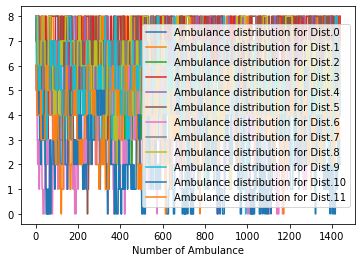

Average Number of IDLING 🚑 Over Time: 5.148319892473118


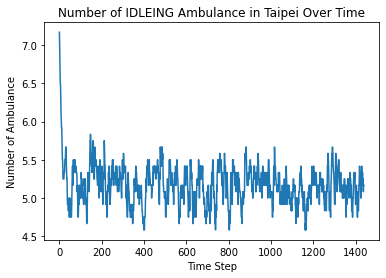



Patient info for each district:
District 0: []

District 1: []

District 2: []

District 3: []

District 4: [('⌛️: 1440', 'Dist: 4'), ('⌛️: 1447', 'Dist: 4'), ('⌛️: 1449', 'Dist: 4')]

District 5: [('⌛️: 1443', 'Dist: 5'), ('⌛️: 1444', 'Dist: 5'), ('⌛️: 1444', 'Dist: 5'), ('⌛️: 1451', 'Dist: 5')]

District 6: [('⌛️: 1441', 'Dist: 6'), ('⌛️: 1465', 'Dist: 6')]

District 7: [('⌛️: 1443', 'Dist: 7'), ('⌛️: 1446', 'Dist: 7')]

District 8: [('⌛️: 1450', 'Dist: 8'), ('⌛️: 1451', 'Dist: 8'), ('⌛️: 1451', 'Dist: 8')]

District 9: [('⌛️: 1448', 'Dist: 9'), ('⌛️: 1452', 'Dist: 9'), ('⌛️: 1452', 'Dist: 9'), ('⌛️: 1455', 'Dist: 9')]

District 10: [('⌛️: 1442', 'Dist: 10'), ('⌛️: 1450', 'Dist: 10'), ('⌛️: 1460', 'Dist: 10'), ('⌛️: 1461', 'Dist: 10'), ('⌛️: 1464', 'Dist: 10')]

District 11: [('⌛️: 1444', 'Dist: 11'), ('⌛️: 1449', 'Dist: 11'), ('⌛️: 1456', 'Dist: 11')]



In [104]:
# We use other input to see the snapshot of the system after running 1440 steps for ONE trial 

weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]

average_call_time = 0.5 
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])
amb_deploy = [(0,6),(1,8), (2,6),(3,8),(4,8),(5,8),(6,6),(7,8),(8,8),(9,8),(10,6),(11,6)]

taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
taipei.initialize()
for i in range(1440):
    taipei.update()

for s in taipei.district_list: 
    taipei.total_wait_time += taipei.graph.nodes[s]['district'].wait_time

taipei.observe()

# Simulation Starts

## Strategy 1
Input set up 
- amb_deploy = We chose 3 depots to place in districts located in the city center (district 4,6,9) 


- average_call_time = 0.5 : we set it to 0.5 because there is a call coming in every 30 sec. 
- weighted_edges: We set up the edges according to the time that Google map calculated for cross-district travel time
- total_trial: 500 
- population = [9,11,5,7,9,6,12,10,8,8,10,5]: according to the Taipei Government data about population in each district
- Total number of ambulance: 86: according to the number of total ambulance in Tiapei


In [173]:
# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy = [(4,36), (6,20),(9,30)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)


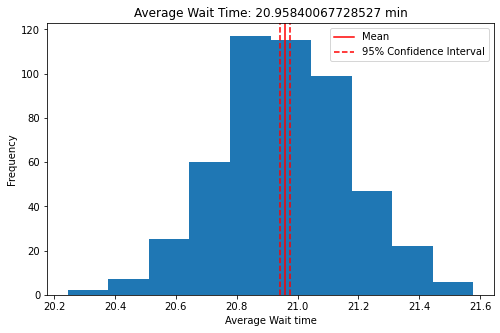

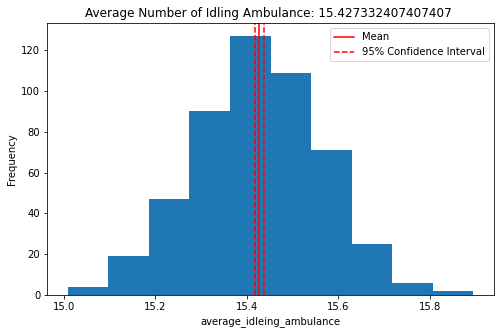

In [174]:
# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()



plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


## Strategy 2
Input set up 
- amb_deploy = We chose 3 depots to place in districts in-between the city center and city border  (district 1,5,8)


- average_call_time = 0.5 : we set it to 0.5 because there is a call coming in every 30 sec. 
- weighted_edges: We set up the edges according to the time that Google map calculated for cross-district travel time
- total_trial: 500 
- population = [9,11,5,7,9,6,12,10,8,8,10,5]: according to the Taipei Government data about population in each district
- Total number of ambulance: 86: according to the number of total ambulance in Tiapei


In [175]:
# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy = [(8,30), (5,20),(1,36)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)


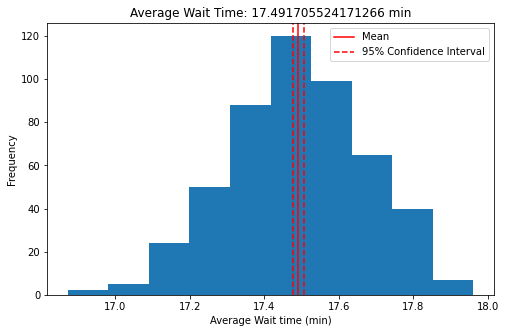

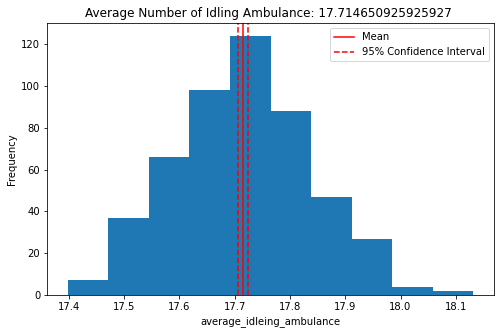

In [176]:
# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time (min)')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()


plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


## Strategy 3
Input set up 
- amb_deploy = We chose 4 depots to place in districts located in-between the city center and border (district 1,5,8,9)


- average_call_time = 0.5 : we set it to 0.5 because there is a call coming in every 30 sec. 
- weighted_edges: We set up the edges according to the time that Google map calculated for cross-district travel time
- total_trial: 500 
- population = [9,11,5,7,9,6,12,10,8,8,10,5]: according to the Taipei Government data about population in each district
- Total number of ambulance: 86: according to the number of total ambulance in Tiapei


In [162]:
# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy = [(1,21),(9,21), (5,21),(8,22)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)

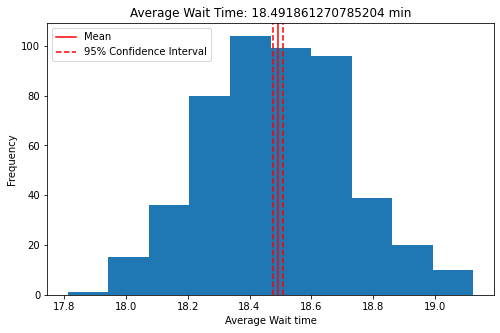

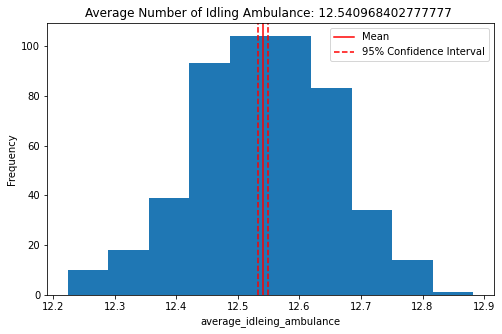

In [163]:
# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()



plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()

## Strategy 4
Input set up 
- amb_deploy = We chose 5 depots to place in districts located in-between the city center and border (district 1,2, 5,8,9)


- average_call_time = 0.5 : we set it to 0.5 because there is a call coming in every 30 sec. 
- weighted_edges: We set up the edges according to the time that Google map calculated for cross-district travel time
- total_trial: 500 
- population = [9,11,5,7,9,6,12,10,8,8,10,5]: according to the Taipei Government data about population in each district
- Total number of ambulance: 86: according to the number of total ambulance in Tiapei


In [160]:
# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]

average_call_time = 0.5 

amb_deploy = [(1,17), (2,17), (5,17),(8,17),(9,17)]
 
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)


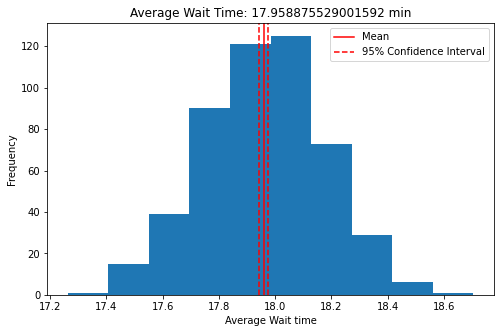

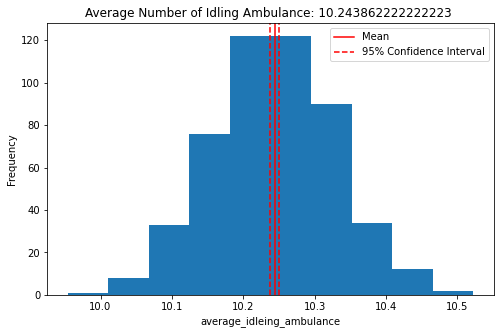

In [161]:
# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()



plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()

## Strategy 5
Input set up 
- amb_deploy = We chose 11 depots to place in districts


- average_call_time = 0.5 : we set it to 0.5 because there is a call coming in every 30 sec. 
- weighted_edges: We set up the edges according to the time that Google map calculated for cross-district travel time
- total_trial: 500 
- population = [9,11,5,7,9,6,12,10,8,8,10,5]: according to the Taipei Government data about population in each district
- Total number of ambulance: 86: according to the number of total ambulance in Tiapei


In [170]:
# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy = [(1,9), (2,9),(3,8),(4,8),(5,9),
              (6,8),(7,8),(8,9),(9,9),(10,8),(11,8)] 
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)


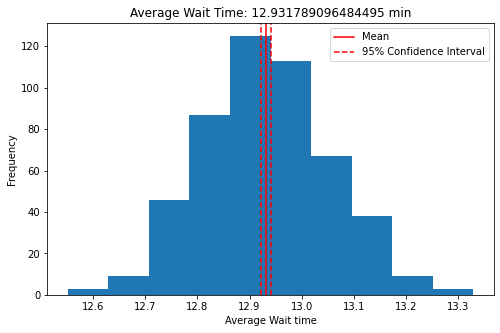

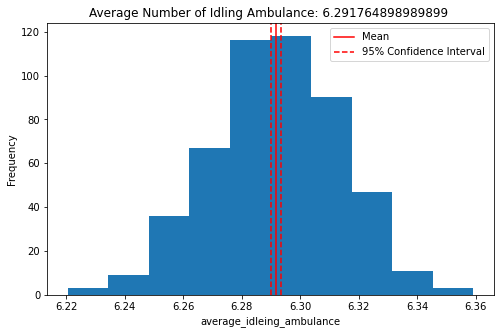

In [172]:
# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()


plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


## Strategy 6
Input set up 
- amb_deploy = We chose all 12 depots to place in districts


- average_call_time = 0.5 : we set it to 0.5 because there is a call coming in every 30 sec. 
- weighted_edges: We set up the edges according to the time that Google map calculated for cross-district travel time
- total_trial: 500 
- population = [9,11,5,7,9,6,12,10,8,8,10,5]: according to the Taipei Government data about population in each district
- Total number of ambulance: 86: according to the number of total ambulance in Tiapei


In [121]:
# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 

amb_deploy = [(0,8),(1,8), (2,6),(3,8),(4,8),(5,8),(6,6),(7,8),(8,8),(9,8),(10,6),(11,6)]
 
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)


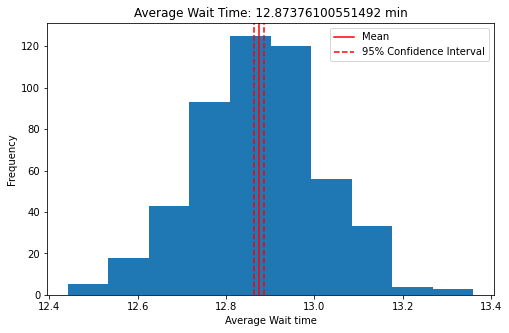

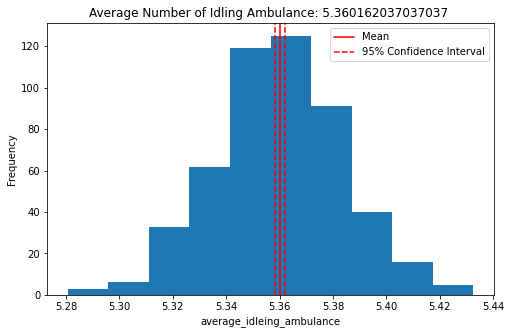

In [122]:
# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()



plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


# Theoretical Analysis 

In [7]:
# Fit the data 
import scipy.optimize
import math
from sklearn.linear_model import LinearRegression

number_of_station = np.array([3,4,5,11,12])
number_of_station = number_of_station.reshape(-1, 1)
average_wait_time = np.array([18.8,18.7,16.5,14.3,12.9])
average_wait_time = average_wait_time.reshape(-1, 1)

reg = LinearRegression().fit(number_of_station, average_wait_time)
reg.score(number_of_station, average_wait_time)

print(reg.coef_)
print(reg.intercept_)

[[-0.60857143]]
[20.5]


## Asessing Model Predictive Power - Training Set

In [31]:
math_predict = reg.predict(np.array([[3], [4], [5],[11],[12]])) 
print(f"Mathematical Prediction: \n{math_predict}\n")

# Train set error
error = abs(math_predict - average_wait_time)/average_wait_time
print(f"Mean percentage error: \n{np.mean(error)}")

Mathematical Prediction: 
[[18.67428571]
 [18.06571429]
 [17.45714286]
 [13.80571429]
 [13.19714286]]

Mean percentage error: 
0.031242874966133698


## Test Set Generation

6 stations


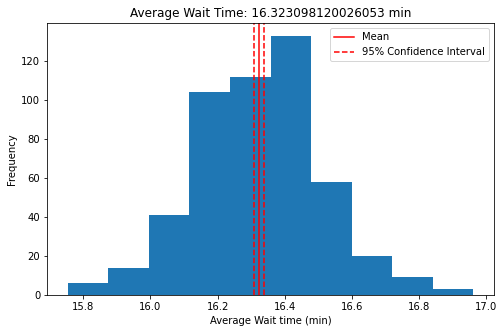

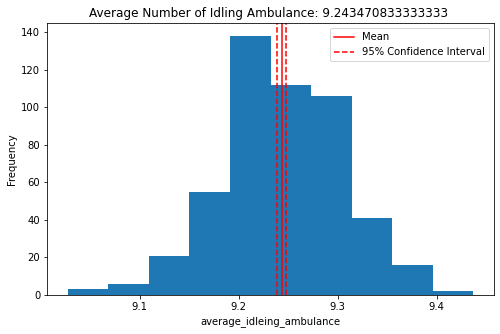

In [33]:
# Run 6

print("6 stations")

# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy = [(8,14), (5,14),(1,15), (2,14), (9,15), (10,14)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)

# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time (min)')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()


plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


7 stations


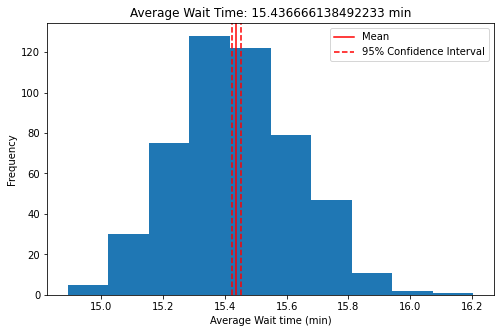

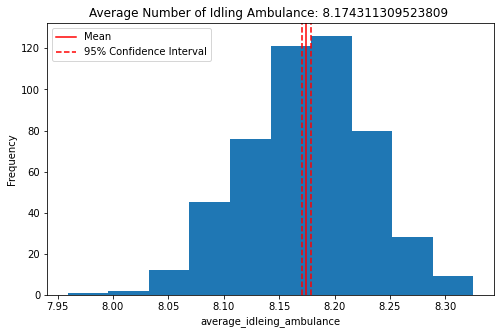

In [34]:
# Run 7

print("7 stations")

# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy =[(8,12), (5,12),(1,13), (2,12), (9,12), (10,13),(7,12)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)

# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time (min)')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()


plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


8 stations


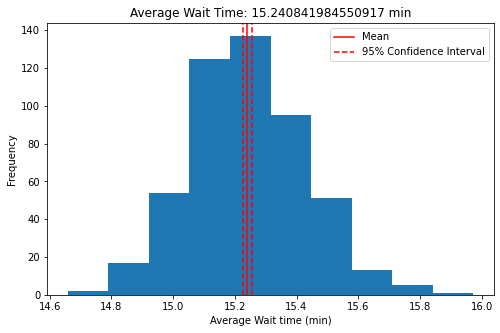

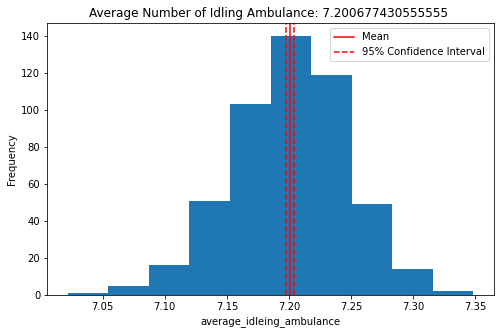

In [35]:
# Run 8

print("8 stations")

# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy =[(8,11), (5,11),(1,11), (2,11), (9,10), (10,11),(7,10), (0,11)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)

# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time (min)')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()


plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


9 stations


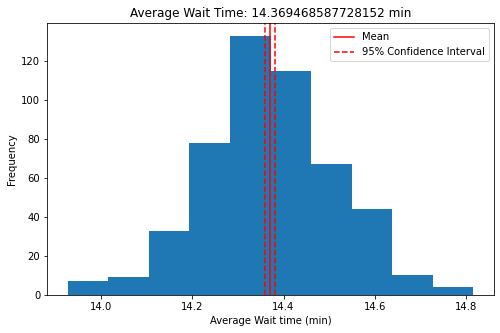

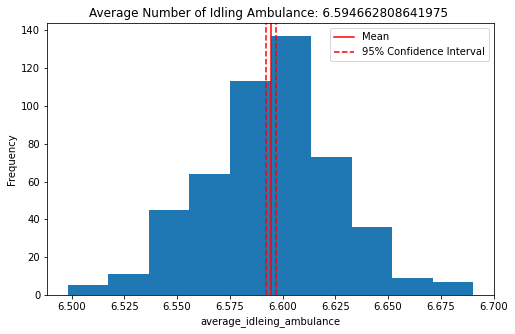

In [36]:
# Run 9

print("9 stations")

# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy =[(8,10), (5,10),(1,10), (2,9), (9,9), (10,10),(7,10), (0,9), (11,9)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)

# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time (min)')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()


plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


10 stations


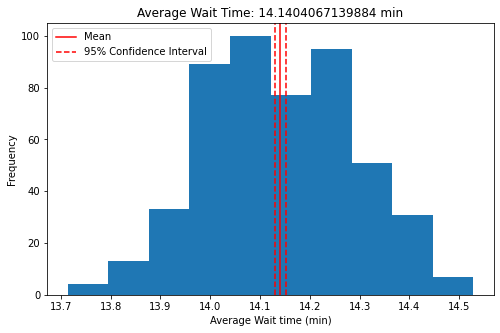

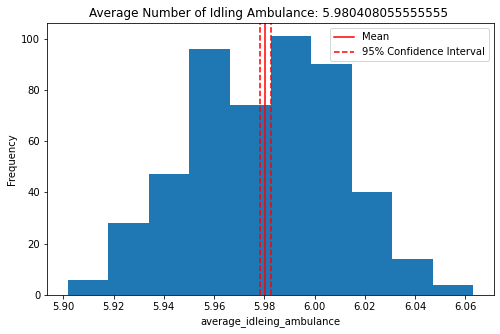

In [37]:
# Run 10

print("10 stations")

# Run the same parameter for multiple trials to get the distribution
weighted_edges = [[0, 1, 8]  , [1, 2, 6], [1, 4, 5], 
                   [1, 10, 10] , [2, 4, 5], 
                   [2, 5, 6]  , [2, 3, 8]  , [3, 5, 6], 
                   [4, 5, 10]  , [4, 6, 8], [4, 9, 10], 
                   [9, 10, 5] , [5, 6, 8]  , [5, 7, 16], 
                   [6, 7, 6]  , [6, 8, 7]  , [6, 9, 8], 
                   [7, 8, 9]  , [8, 9, 9]  , [8, 10, 5], 
                   [8, 11, 14] , [9, 10, 5] , [10, 11, 12]]
average_call_time = 0.5 
amb_deploy =[(8,9), (5,9),(1,9), (2,9), (9,9), (10,9),(7,8), (0,8), (11,8), (3,8)]
population = np.array([9,11,5,7,9,6,12,10,8,8,10,5])

total_trial = 500
average_wait_time = []
average_idleing_amb = []

for trial in range(total_trial):
    taipei = simulation(weighted_edges, average_call_time, amb_deploy, population)
    taipei.initialize()
    for i in range(1440):
        taipei.update()
    
    district_ambulance_idle = np.zeros(taipei.time)

    
    for i in taipei.district_list:  
        taipei.total_wait_time += taipei.graph.nodes[i]['district'].wait_time
        district_ambulance_idle += np.array(taipei.dist_ambulance[i])
        
    district_ambulance_idle /= len(taipei.district_list)
    average_wait_time.append(np.mean(taipei.total_wait_time))
    average_idleing_amb.append(np.mean(district_ambulance_idle))

    
    print(f'Trial {trial+1}/{total_trial}', end = '\r')
    time.sleep(0.00001)

# The results for 500 Trials

plt.figure(figsize = (8,5))
plt.hist(average_wait_time)
plt.axvline(np.mean(average_wait_time), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_wait_time) + 1.69*sts.sem(average_wait_time), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_wait_time) - 1.69*sts.sem(average_wait_time), color = 'red', linestyle='--' )

plt.xlabel('Average Wait time (min)')
plt.ylabel('Frequency')
plt.title(f'Average Wait Time: {np.mean(average_wait_time)} min')
plt.legend()
plt.show()


plt.figure(figsize = (8,5))
plt.hist(average_idleing_amb)
plt.axvline(np.mean(average_idleing_amb), color = 'red', label = 'Mean')
plt.axvline(np.mean(average_idleing_amb) + 1.69*sts.sem(average_idleing_amb), color = 'red', label = '95% Confidence Interval', linestyle='--' )
plt.axvline(np.mean(average_idleing_amb) - 1.69*sts.sem(average_idleing_amb), color = 'red', linestyle='--' )

plt.xlabel('average_idleing_ambulance')
plt.ylabel('Frequency')
plt.title(f'Average Number of Idling Ambulance: {np.mean(average_idleing_amb)} ')
plt.legend()
plt.show()


## Asessing Model Predictive Power - Testing Set

In [38]:
math_predict = reg.predict(np.array([[6], [7], [8],[9],[10]])) 
print(f"Mathematical Prediction: \n{math_predict}\n")

# Train set error
average_wait_time_test = np.array([16.3, 15.4, 15.2, 14.3, 14.1])
error = abs(math_predict - average_wait_time_test)/average_wait_time_test
print(f"Mean percentage error: \n{np.mean(error)}")

Mathematical Prediction: 
[[16.84857143]
 [16.24      ]
 [15.63142857]
 [15.02285714]
 [14.41428571]]

Mean percentage error: 
0.07206917935740026
